In [31]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Convolution2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats

In [33]:

data = pd.read_csv('data/app_data.csv', index_col=False)
data = data.dropna()
data['X'] = data['X'].astype(float)
data['Y'] = data['Y'].astype(float)
data['Z'] = data['Z'].astype(float)
data['Activity'] = data['Activity'].str.rstrip(';')
data['Activity'] = data['Activity'].str.strip()
corrections = {
    'Walkin': 'Walking',
    'Eating Popconr': 'Eating Popcorn'
}
data['Activity'] = data['Activity'].replace(corrections)

/var/folders/mn/35k8vrvj7z9046dsf_t68vzh0000gn/T/ipykernel_24586/140840955.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv('data/app_data.csv', index_col=False)


In [5]:
# Isolate the X, Y, Z
data = data.drop(['SessionID', 'DeviseID', 'UserID', 'Date', 'Year', 'TimeStamp'], axis=1)
# Balance the dataset by selecting a specific number of rows for each activity
drinking_water = data[data['Activity'] == 'Drinking Water'].head(1200)
vaping = data[data['Activity'] == 'Vaping'].head(1200)
typing = data[data['Activity'] == 'Typing'].head(1200)
eating_popcorn = data[data['Activity'] == 'Eating Popconr'].head(1200)
walking = data[data['Activity'] == 'Walking'].head(1200)
balanced_data = pd.DataFrame()
balanced_data = pd.concat([drinking_water, vaping, typing, eating_popcorn, walking])


In [6]:
# Encode the activity label
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['Activity'])

In [7]:
# Standardise the data
X = balanced_data[['X', 'Y', 'Z']]
y = balanced_data['label']

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(data=X, columns=['X', 'Y', 'Z'])
scaled_X['label'] = y.values

In [9]:
scaled_X.shape

(4800, 4)

In [10]:
def get_windows(df, window_size, step_size):
    

    windows = []
    labels = []
    num_features = 3
    for i in range(0, len(df) - window_size, step_size):
        xs = df['X'].values[i: i + window_size]
        ys = df['Y'].values[i: i + window_size]
        zs = df['Z'].values[i: i + window_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + window_size])[0]
        windows.append([xs, ys, zs])
        labels.append(label)
        
    windows = np.asarray(windows).reshape(-1, window_size, num_features)
    labels = np.asarray(labels)
    
    return windows, labels

In [15]:
x, y = get_windows(scaled_X, 10, 5)

In [16]:
x.shape, y.shape

((958, 10, 3), (958,))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1, stratify=y)

In [18]:
X_train.shape , X_test.shape

((766, 10, 3), (192, 10, 3))

In [19]:
print("Original shape of X_train:", X_train.shape)
print("Total elements in X_train:", X_train.size)

Original shape of X_train: (766, 10, 3)
Total elements in X_train: 22980


In [20]:
num_samples = X_train.shape[0]
window_size = X_train.shape[1]
num_features = X_train.shape[2]
print(f"Num Samples: {num_samples}, Window Size: {window_size}, Num Features: {num_features}")


Num Samples: 766, Window Size: 10, Num Features: 3


In [21]:
X_train = X_train.reshape(-1, 10, 3, 1)  # Replace `10` and `3` with actual values
X_test = X_test.reshape(-1, 10, 3, 1)   # Ensure the same reshaping logic


In [22]:
y_train.shape, y_test.shape

((766,), (192,))

In [23]:
model = Sequential()
model.add(Convolution2D(16, (2,2), activation= 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Convolution2D(32, (2,2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation= 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

/opt/anaconda3/envs/ml-project-tf_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile(optimizer=Adam(learning_rate=0.001), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_test, y_test), verbose= 1)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3003 - loss: 1.6668 - val_accuracy: 0.6979 - val_loss: 1.0988
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5780 - loss: 1.1054 - val_accuracy: 0.6979 - val_loss: 0.7340
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6822 - loss: 0.8654 - val_accuracy: 0.7188 - val_loss: 0.6990
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7022 - loss: 0.7800 - val_accuracy: 0.7292 - val_loss: 0.6425
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7137 - loss: 0.7704 - val_accuracy: 0.7240 - val_loss: 0.6630
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7197 - loss: 0.7099 - val_accuracy: 0.7344 - val_loss: 0.6275
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7344 - loss: 0.6878 - val_accuracy: 0.7396 - val_loss: 0.6151
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7662 - loss: 0.6262 - val_accuracy: 0.7292 - val_loss:

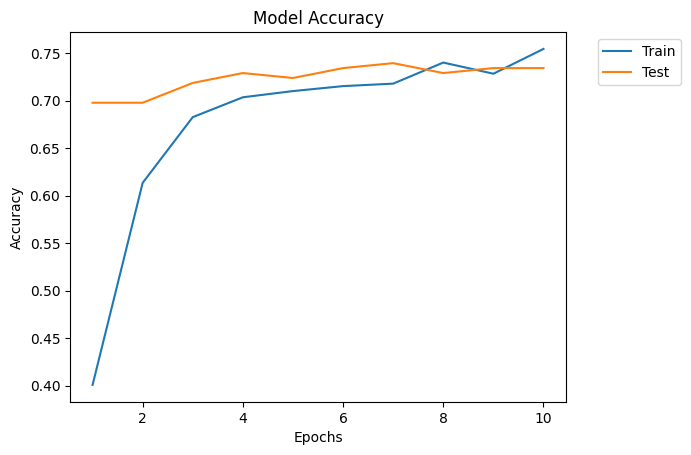

In [26]:
# Learning Curve
# Plot training and validataion accuracy values
epoch_range = range(1, 11)
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'], bbox_to_anchor=(1.05, 1))
plt.show()


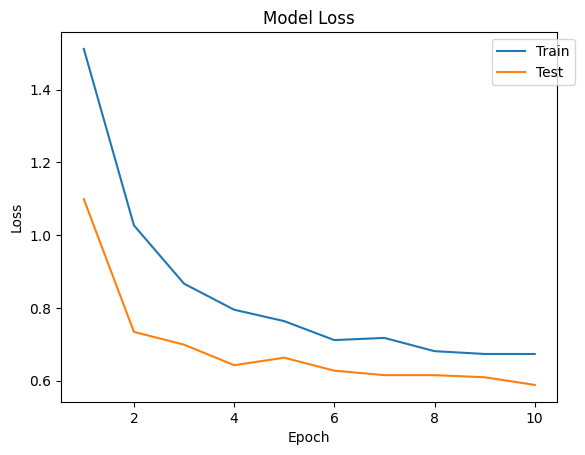

In [27]:
# Plot of training and validation loss:
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'], bbox_to_anchor=(1.05, 1))
plt.show()

In [28]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [29]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


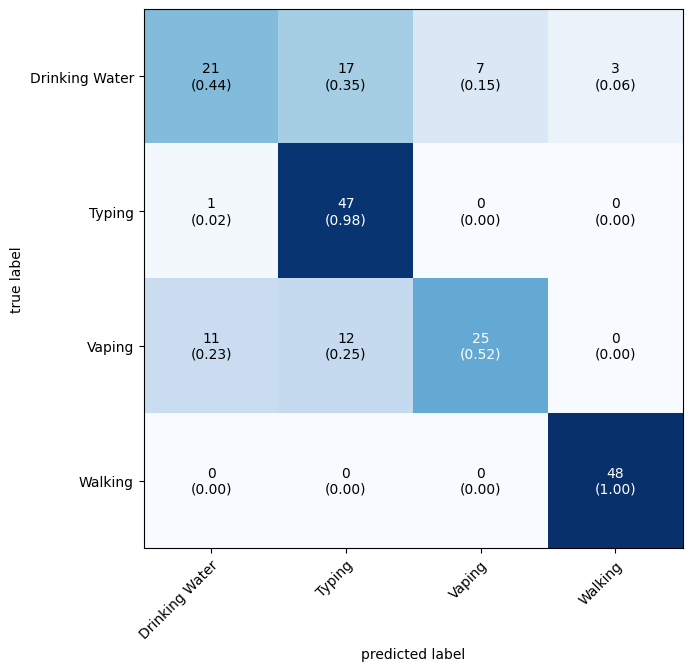

In [30]:
matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=matrix, class_names=label.classes_, show_normed=True, figsize=(7,7))
plt.show()